In this problem we will train a neural network from scratch using numpy. In practice, you will never need to do this (you'd just use TensorFlow or PyTorch). But hopefully this will give us a sense of what's happening under the hood. 

For training/testing, we will use the standard MNIST benchmark consisting of images of handwritten images. 



In the second demo, we worked with autodiff. Autodiff enables us to implicitly store how to calculate the gradient when we call backward. We implemented some basic operations (addition, multiplication, power, and ReLU). In this homework problem, you will implement backprop for more complicated operations directly. Instead of using autodiff, you will manually compute the gradient of the loss function for each parameter.

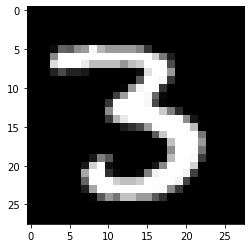

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[12],cmap='gray');

Loading MNIST is the only place where we will use TensorFlow; the rest of the code will be pure numpy.

Let us now set up a few helper functions. We will use sigmoid activations for neurons, the softmax activation for the last layer, and the cross entropy loss.

In [67]:
import numpy as np

def sigmoid(x):
  # Numerically stable sigmoid function based on
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  
  x = np.clip(x, -500, 500) # We get an overflow warning without this
  
  return np.where(
    x >= 0,
    1 / (1 + np.exp(-x)),
    np.exp(x) / (1 + np.exp(x))
  )

def dsigmoid(x): # Derivative of sigmoid
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  # Numerically stable softmax based on (same source as sigmoid)
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
  # x: integer to convert to one hot encoding
  # max: the size of the one hot encoded array
  result = np.zeros(max)
  result[x] = 1
  return result

OK, we are now ready to build and train our model. The input is an image of size 28x28, and the output is one of 10 classes. So, first: 

Q1. Initialize a 2-hidden layer neural network with 32 neurons in each hidden layer, i.e., your layer sizes should be: 

784 -> 32 -> 32 -> 10

If the layer is $n_{in} \times n_{out}$ your layer weights should be initialized by sampling from a normal distribution with mean zero and variance 1/$\max(n_{in},n_{out})$.

In [90]:
import math

# Initialize weights of each layer with a normal distribution of mean 0 and
# standard deviation 1/sqrt(n), where n is the number of inputs.
# This means the weighted input will be a random variable itself with mean
# 0 and standard deviation close to 1 (if biases are initialized as 0, standard
# deviation will be exactly 1)

from numpy.random import default_rng

rng = default_rng(44017)

# Q1. Fill initialization code here.
# ...

# Generate initial weight and biases parameters

weights = [rng.normal(0, 1 / (784), (32, 784)), rng.normal(0, 1 / (32), (32, 32)), rng.normal(0, 1 / (32), (10, 32))] 
biases = [np.zeros(32), np.zeros(32), np.zeros(10)]


Next, we will set up the forward pass. We will implement this by looping over the layers and successively computing the activations of each layer. 

Q2. Implement the forward pass for a single sample, and for the entire dataset.


Right now, your network weights should be random, so doing a forward pass with the data should not give you any meaningful information. Therefore, in the last line, when you calculate test accuracy, it should be somewhere around 1/10 (i.e., a random guess).

In [69]:
def feed_forward_sample(sample, ground_truth_label):
  """ Forward pass through the neural network.
    Inputs:
      sample: 1D numpy array. The input sample (an MNIST digit).
      label: An integer from 0 to 9.

    Returns: the cross entropy loss, most likely class
  """
  # Q2. Fill code here.
  
  # First we need to flatten the input image to a 1-D vector
  layer_output = sample.flatten() # The flattened image size is (1, 28*28) = (1, 784)

  # Then we pass the input forward to each layer
  for index in range(3):
    neurons_before_activation = np.matmul(weights[index], layer_output) + biases[index] # forward to next layer
    if index == 2:
      layer_output = softmax(neurons_before_activation) # If we reach the output layer, we use softmax to compute the probabilty
    else:
      layer_output = sigmoid(neurons_before_activation)# Otherwise, we use sigmoid as activation function

  # Calculate ground truth distribution
  ground_truth_label_distribution = integer_to_one_hot(ground_truth_label, 10)
  # Calculate the crossentropy loss
  loss = cross_entropy_loss(ground_truth_label_distribution, layer_output)

  # Get the predicted label
  predicted_label = np.argmax(layer_output)
  
  # Set the predicted output distribution
  one_hot_guess = np.zeros_like(layer_output)
  one_hot_guess[predicted_label] = 1

  return loss, one_hot_guess


def feed_forward_dataset(x, y):
  num_of_dataset = x.shape[0]
  losses = np.empty(num_of_dataset)
  one_hot_guesses = np.empty((num_of_dataset, 10))


  # ...
  # Q2. Fill code here to calculate losses, one_hot_guesses
  # ...
  for i in range(num_of_dataset):
    losses[i], one_hot_guesses[i] = feed_forward_sample(x[i], y[i])

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")  

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))
  print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")

def feed_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def feed_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")

feed_forward_test_data()

Feeding forward all test data...

Average loss: 2.31
Accuracy (# of correct guesses): 1009.0 / 10000 ( 10.09 %)



OK, now we will implement the backward pass using backpropagation. We will keep it simple and just do training sample-by-sample (no minibatching, no randomness).

Q3: Compute the gradient of all the weights and biases by backpropagating derivatives all the way from the output to the first layer. 





In [97]:
def train_one_sample(sample, ground_truth_label, learning_rate=0.003):
  layer_output = sample.flatten()

  # We will store each layer's activations to calculate gradient
  activations = []

  # Forward pass

  # Q3. This should be the same as what you did in feed_forward_sample above.
  for index in range(3):
    neurons_before_activation = np.matmul(weights[index], layer_output) + biases[index] # forward to next layer
    if index == 2:
      layer_output = softmax(neurons_before_activation) # If we reach the output layer, we use softmax to compute the probabilty
    else:
      layer_output = sigmoid(neurons_before_activation) # Otherwise, we use sigmoid as activation function

    # After each layer, we need to store the activations
    activations.append(layer_output)
  
  # Calculate ground truth distribution and the loss
  ground_truth_label_distribution = integer_to_one_hot(ground_truth_label, 10)
  loss = cross_entropy_loss(ground_truth_label_distribution, layer_output)

  # Get the predicted label
  predicted_label = np.argmax(layer_output)
  # Set the predicted output distribution
  one_hot_guess = np.zeros_like(layer_output)
  one_hot_guess[predicted_label] = 1

  # Check if we got the correct prediction
  corrected_prediction = (predicted_label == ground_truth_label)


  # Backward pass

  # Q3. Implement backpropagation by backward-stepping gradients through each layer.
  # You may need to be careful to make sure your Jacobian matrices are the right shape.
  # At the end, you should get two vectors: weight_gradients and bias_gradients.
  
  # Declare variables
  num_of_layers = 3
  weight_gradients = [None] * num_of_layers
  bias_gradients = [None] * num_of_layers
  activation_gradients = [None] * (num_of_layers - 1)

  for i in range(len(weights) - 1, -1, -1): # Traverse layers in reverse
    if i == num_of_layers - 1:
      # If it is the last layer
      output_y = ground_truth_label_distribution[:, np.newaxis]
      current_activation = activations[i][:, np.newaxis]
      previous_activation = activations[i - 1][:, np.newaxis]

      weight_gradients[i] = np.matmul((current_activation - output_y), previous_activation.T)
      bias_gradients[i] = current_activation - output_y

    else:
      next_layer_weights = weights[i + 1]
      next_layer_activation = activations[i + 1][:, np.newaxis]
      output_y = ground_truth_label_distribution[:, np.newaxis]
      current_activation = activations[i][:, np.newaxis]

      # Calculate the activation gradients
      if i == num_of_layers - 2:
        activation_gradient = np.matmul(next_layer_weights.T, (next_layer_activation - output_y))
        activation_gradients[i] = activation_gradient
      else:
        activation_gradient_next = activation_gradients[i+1]
        activation_gradient = np.matmul(next_layer_weights.T, (dsigmoid(next_layer_activation) * activation_gradient_next))
        activation_gradients[i] = activation_gradient
      
      # Get the previous activation 
      if i > 0:
        previous_activation = activations[i - 1][:, np.newaxis]
      else:
        previous_activation = sample.flatten()[:, np.newaxis]


      # Calculate the gradients with respect to weights and biases 
      x = dsigmoid(current_activation) * activation_gradient
      weight_gradients[i] = np.matmul(x, previous_activation.T)
      bias_gradients[i] = x

    weights[i] -= weight_gradients[i] * learning_rate
    biases[i] -= bias_gradients[i].flatten() * learning_rate


Finally, train for 3 epochs by looping over the entire training dataset 3 times.

Q4. Train your model for 3 epochs.

In [98]:
def train_one_epoch(learning_rate=0.003):
  print("Training for one epoch over the training dataset...")
  
  # Q4. Write the training loop over the epoch here.
  # ...
  num_of_training_set = x_train.shape[0]
  for i in range(num_of_training_set):
    if i == 0 or ((i + 1) % 10000 == 0):
      completion_percent = format(((i + 1) / x_train.shape[0]) * 100, ".2f")
      print(i + 1, "/", x_train.shape[0], "(", completion_percent, "%)")
    train_one_sample(x_train[i], y_train[i], learning_rate)
  print("Finished training.\n")


feed_forward_test_data()

def test_and_train():
  train_one_epoch()
  feed_forward_test_data()

for i in range(3): 
  test_and_train()

Feeding forward all test data...

Average loss: 2.31
Accuracy (# of correct guesses): 1014.0 / 10000 ( 10.14 %)

Training for one epoch over the training dataset...
1 / 60000 ( 0.00 %)
10000 / 60000 ( 16.67 %)
20000 / 60000 ( 33.33 %)
30000 / 60000 ( 50.00 %)
40000 / 60000 ( 66.67 %)
50000 / 60000 ( 83.33 %)
60000 / 60000 ( 100.00 %)
Finished training.

Feeding forward all test data...

Average loss: 0.99
Accuracy (# of correct guesses): 6978.0 / 10000 ( 69.78 %)

Training for one epoch over the training dataset...
1 / 60000 ( 0.00 %)
10000 / 60000 ( 16.67 %)
20000 / 60000 ( 33.33 %)
30000 / 60000 ( 50.00 %)
40000 / 60000 ( 66.67 %)
50000 / 60000 ( 83.33 %)
60000 / 60000 ( 100.00 %)
Finished training.

Feeding forward all test data...

Average loss: 0.8
Accuracy (# of correct guesses): 7515.0 / 10000 ( 75.15 %)

Training for one epoch over the training dataset...
1 / 60000 ( 0.00 %)
10000 / 60000 ( 16.67 %)
20000 / 60000 ( 33.33 %)
30000 / 60000 ( 50.00 %)
40000 / 60000 ( 66.67 %)
5000


That's it! 

Your code is probably very time- and memory-inefficient; that's ok. There is a ton of optimization under the hood in professional deep learning frameworks which we won't get into.

If everything is working well, you should be able to raise the accuracy from ~10% to ~70% accuracy after 3 epochs.